# W261 Final Project ETL for Development Sample

## Notebook Set-Up

In [1]:
# imports
import time
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from pyspark.sql import Row
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]
PWD

'/media/notebooks'

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261FinalProject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`NOTE:`__ Monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

## Pre-Processing

### Load Data

In [5]:
original_trainRDD = sc.textFile('data/train.txt')
#original_testRDD = sc.textFile('data/test.txt')

### Sample Data

In [19]:
#change the seed for a different sample
largeRDD, smallTestRDD, smallTrainRDD = original_trainRDD.randomSplit([0.99, 0.005, 0.005], seed = 1)
smallTrainRDD.cache()
smallTestRDD.cache()

PythonRDD[55] at RDD at PythonRDD.scala:49

In [20]:
ncol = len(smallTrainRDD.take(1)[0].split('\t'))
nrow = smallTrainRDD.count()
print(f'This sample contains {nrow} rows and {ncol} columns')

This sample contains 229937 rows and 40 columns


In [21]:
def avgFeatures(line):
    
    count = 0
    feats = line.split('\t')[1:]
    
    for feat in feats:
        if feat != '':
            count += 1

    return count

print("There is an average of", str(round(smallTrainRDD.map(avgFeatures).mean(),2)), "populated features per observation.")

There is an average of 33.46 populated features per observation.


### Normalize Data

### Dimension Reduction

### Transformation

In [22]:
# function to parse raw data and tag feature values with type and feature indices
def parseCV(line):
    """
    Map record_csv_string --> (label, features)
    """

    # start of categorical features
    col_start = 14
    
    raw_values = line.split('\t')
    label = int(raw_values[0])
    
    # parse numeric features
    numericals = []
    for idx, value in enumerate(raw_values[1:col_start]):
        if value != '':
            numericals.append('n' + str(idx) + '_' + str(value))
            
    # parse categorical features
    categories = []
    for idx, value in enumerate(raw_values[col_start:]):
        if value != '':
            categories.append('c'+ str(idx) + '_' + str(value))

    return Row(label=label, raw=numericals + categories)

# function to one hot encode all features using a count vectorizer
def vectorizeCV(DF):
    
    vectorizer = CountVectorizer()
    cv = CountVectorizer(minDF=.001, inputCol="raw", outputCol="features")
    
    model = cv.fit(DF)
    result = model.transform(DF)
    
    return result, model

# call functions
parsedDF = smallTrainRDD.map(parseCV).toDF().cache()
vectorizedDF, cvModel = vectorizeCV(parsedDF)

In [23]:
vectorizedDF.show(truncate=True)

+-----+--------------------+--------------------+
|label|                 raw|            features|
+-----+--------------------+--------------------+
|    0|[n1_1, n2_2, n4_6...|(2595,[0,1,3,5,14...|
|    0|[n0_0, n1_211, n2...|(2595,[0,2,3,4,5,...|
|    0|[n1_5, n2_5, n3_0...|(2595,[0,1,2,4,5,...|
|    0|[n0_2, n1_48, n2_...|(2595,[0,1,2,8,9,...|
|    0|[n1_-1, n2_0, n7_...|(2595,[1,3,9,15,3...|
|    1|[n0_5, n1_44, n2_...|(2595,[0,2,4,5,8,...|
|    1|[n0_3, n1_-1, n2_...|(2595,[0,2,3,4,7,...|
|    0|[n0_0, n1_7, n2_1...|(2595,[0,1,2,3,4,...|
|    0|[n0_11, n1_1, n2_...|(2595,[0,1,2,3,4,...|
|    0|[n0_2, n1_3, n2_5...|(2595,[0,3,10,12,...|
|    0|[n1_29, n2_1, n3_...|(2595,[5,7,14,15,...|
|    0|[n0_10, n1_0, n2_...|(2595,[0,1,2,3,5,...|
|    0|[n0_0, n1_8, n2_1...|(2595,[1,2,3,4,11...|
|    0|[n0_0, n1_0, n2_3...|(2595,[0,1,2,4,5,...|
|    0|[n0_1, n1_-1, n4_...|(2595,[0,1,2,3,4,...|
|    0|[n1_2959, n2_2, n...|(2595,[0,1,2,3,6,...|
|    0|[n0_1, n1_1, n2_8...|(2595,[0,2,3,8,9,...|


In [26]:
vectorizedRDD = vectorizedDF.select(['label', 'features']).rdd.cache()

In [25]:
num_feats = vectorizedRDD.take(1)[0][1].size
percent_pos = vectorizedRDD.map(lambda x: x[0]).mean()

print("Number of total expanded features:", num_feats)
print("Percent of data in the positive class:", percent_pos)

Number of total expanded features: 2595
Percent of data in the positive class: 0.2569399444195585


## Exploratory Data Analysis

## Modeling

In [27]:
def predict_grad(pair, k_br, b_br, w_br, V_br):
    """
        Compute the predicted probability AND return the gradients
        Args:
            pair - records are in (label, sparse feature set) format
        Broadcast:
            b - bias term (scalar)
            w - linear weight vector (array)
            k - number of factors (def=2)
            V - factor matrix of size (d dimensions, k=2 factors)
        Returns:
            predRDD - pair of ([label, predicted probability], [set of weight vectors in csr_matrix format])
    """
    
    label = pair[0]
    feats = pair[1]
    
    # start with linear weight dot product
    linear_sum = np.dot(w_br.value[0][feats.indices], feats.values)

    # factor matrix interaction sum
    factor_sum = 0.0
    lh_factor = [0.0]*k_br.value
    rh_factor = [0.0]*k_br.value
    
    for f in range(0, k_br.value):
        lh_factor[f] = np.dot(V_br.value[f][feats.indices], feats.values)  #KEY--this is used in v_grad matrix below
        rh_factor[f] = np.dot(V_br.value[f][feats.indices]**2, feats.values**2)
        factor_sum += (lh_factor[f]**2 - rh_factor[f])
    factor_sum = 0.5 * factor_sum
    
    pre_prob = b_br.value + linear_sum + factor_sum
    
    prob = 1.0 / (1 + np.exp(-pre_prob))  #logit transformation
    
    #compute Gradients
    b_grad = prob - label
    
    #w_grad = csr_matrix((b_grad*feats.values, feats.indices, np.array([0, feats.indices.size])), (1, w_br.value.shape[1]))
    w_grad = csr_matrix((b_grad*feats.values, (np.zeros(feats.indices.size), feats.indices)), shape=(1, w_br.value.shape[1]))
    #print(w_grad)
    
    # OLD
    #v_grad = csr_matrix((V_br.value.shape[0], V_br.value.shape[1]))
    #for f in range(0, k_br.value):
    #    for i in feats.indices:
    #        i = int(i)
    #        v_grad[(f,i)] = b_grad * (feats[i]*lh_factor[f] - V_br.value[f][i]*(feats[i]**2))
    
    # V test
    v_data = np.array([], dtype=np.float32)
    v_rows = np.array([], dtype=int)
    v_cols = np.array([], dtype=int)
    for i in range(0, k_br.value):
        v_data = np.append(v_data, b_grad*(lh_factor[i]*feats.values - np.multiply(V_br.value[i][feats.indices], feats.values**2)))
        v_rows = np.append(v_rows, [i]*feats.indices.size)
        v_cols = np.append(v_cols, feats.indices)
    v_grad = csr_matrix((v_data, (v_rows, v_cols)), shape=(k_br.value, V_br.value.shape[1]))
    
    return ([label, prob], [b_grad, w_grad, v_grad])

In [28]:
def logLoss(pair):
    """parallelize log loss
        input: ([label, prob], [b_grad, w_grad, v_grad])
    """
    y = pair[0][1]
    
    eps = 1.0e-16
    if pair[0][1] == 0:
        y_hat = eps
    elif pair[0][1] == 1:
        y_hat = 1-eps
    else:
        y_hat = pair[0][1]
    
    return -(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))


In [29]:
def reduceFct(x, y):
    """function for summing bias and weight matrices
        arguments: ([label, pred], [bias, weight, V matrix])
        out:       [sum bias b, sum weight w, sum matrix V]
    """
    b = x[0] + y[0]
    w = x[1] + y[1]
    V = x[2] + y[2]
    return [b, w, V]

In [32]:
def iterateSGD(dataRDD, k, bInit, wInit, vInit, nIter = 2, learningRate = 0.1, useReg = False, regParam = 0.001):

    k_br = sc.broadcast(k)    
    b_br = sc.broadcast(bInit)
    w_br = sc.broadcast(wInit)
    V_br = sc.broadcast(vInit)

    losses = []
    N = dataRDD.count()

    for i in range(0, nIter):
        print('-' * 25 + 'Iteration ' + str(i) + '-' * 25)
        predRDD = dataRDD.map(lambda x: predict_grad(x, k_br, b_br, w_br, V_br)).cache()
        #print(predRDD.take(1))
        
        loss = predRDD.map(logLoss).reduce(lambda a,b: a+b)/N + \
                int(useReg)*(regParam/2)*(np.linalg.norm(w_br.value)**2 + np.linalg.norm(V_br.value)**2)
        losses.append(loss)
        print(f'Current log-loss: {loss}')
        
        # NEW reduce step
        gradRDD = predRDD.values().reduce(reduceFct)
        bGrad = gradRDD[0]/N
        #print(bGrad)
        wGrad = gradRDD[1]/N
        vGrad = gradRDD[2]/N

        # calculate average gradient for b
        #bGrad = predRDD.map(lambda x: x[1][0]).mean()
        print(f"Bias: {bGrad}")

        # calculate average gradient for w
        #wGrad, vGrad = predRDD.map(lambda x: (x[1][1], x[1][2])).reduce(lambda a,b: a+b)
        
        #wGrad = (1/N) * predRDD.map(lambda x: x[1][1]).reduce(lambda a,b: a+b)
        print(f"wGrad shape: {wGrad.shape}")

        # calculate average gradient for V
        #vGrad = (1/N) * predRDD.map(lambda x: x[1][2]).reduce(lambda a,b: a+b)
        print(f"vGrad shape: {vGrad.shape}")

        ############## update weights ##############
        # first, unpersist broadcasts
        #predRDD.unpersist()
        b_br.unpersist()
        w_br.unpersist()
        V_br.unpersist()

        # update
        b_br = sc.broadcast(b_br.value - learningRate * bGrad)
        w_br = sc.broadcast(w_br.value - learningRate * (wGrad.toarray()+int(useReg)*regParam*np.linalg.norm(w_br.value)))
        V_br = sc.broadcast(V_br.value - learningRate * (vGrad.toarray()+int(useReg)*regParam*np.linalg.norm(V_br.value)))
        
    return losses, b_br, w_br, V_br

In [33]:
# initialize weights
np.random.seed(24)
k = 2
b = 0.0
w = np.random.normal(0.0, 0.02, (1, num_feats))
V = np.random.normal(0.0, 0.02, (k, num_feats))

nIter = 5
start = time.time()
losses, b_br, w_br, V_br = iterateSGD(vectorizedRDD, k, b, w, V, nIter, learningRate = 0.1, useReg = True)
print(f'Performed {nIter} iterations in {time.time() - start} seconds')

-------------------------Iteration 0-------------------------
Current log-loss: 0.6936654202123369
Bias: 0.24859971277621198
wGrad shape: (1, 2595)
vGrad shape: (2, 2595)
-------------------------Iteration 1-------------------------
Current log-loss: 0.6921586991909481
Bias: 0.21598579745385182
wGrad shape: (1, 2595)
vGrad shape: (2, 2595)
-------------------------Iteration 2-------------------------
Current log-loss: 0.6873851878068076
Bias: 0.18788512569035803
wGrad shape: (1, 2595)
vGrad shape: (2, 2595)
-------------------------Iteration 3-------------------------
Current log-loss: 0.680703515215261
Bias: 0.16377104401437234
wGrad shape: (1, 2595)
vGrad shape: (2, 2595)
-------------------------Iteration 4-------------------------
Current log-loss: 0.6730514461267978
Bias: 0.14309861737011617
wGrad shape: (1, 2595)
vGrad shape: (2, 2595)
Performed 5 iterations in 1081.3313825130463 seconds


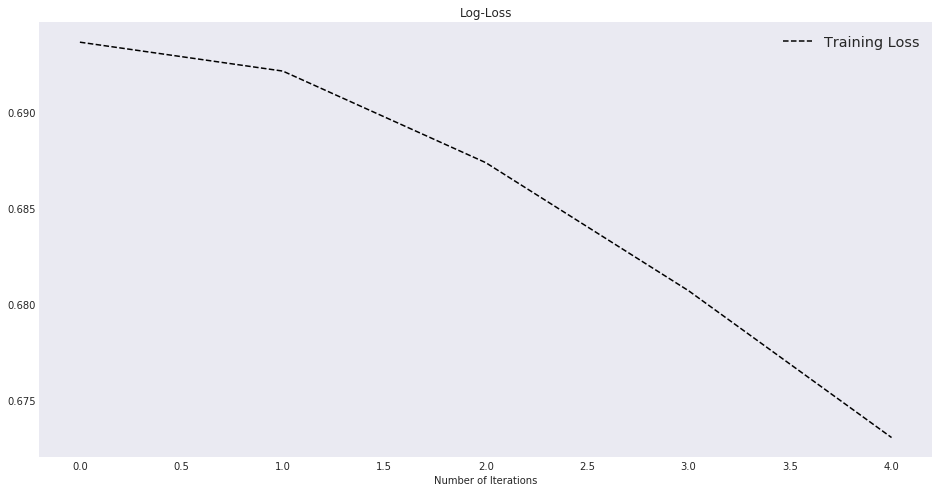

In [34]:
fig, ax = plt.subplots(1,1,figsize = (16,8))
x = list(range(len(losses)))
ax.plot(x, losses, 'k--', label='Training Loss')
ax.legend(loc='upper right', fontsize='x-large')
plt.xlabel('Number of Iterations')
plt.title("Log-Loss")
plt.show()

## Save Model

In [76]:
np.savetxt("model/w_weights.txt", w_br.value, delimiter=',')
np.savetxt("model/V_weights.txt", V_br.value, delimiter=',')

file = open("model/beta.txt", "w")
file.write(str(b_br.value))
file.close()

test_V = np.loadtxt("model/V_weights.txt", delimiter=',')
test_V.shape

(2, 2595)

## Evaluation of Test Set

In [35]:
parsedTestDF = smallTestRDD.map(parseCV).toDF().cache()
vectorizedTestDF = cvModel.transform(parsedTestDF)
vectorizedTestRDD = vectorizedTestDF.select(['label', 'features']).rdd.cache()

In [57]:
tester = vectorizedTestRDD.take(1)[0]

In [61]:
def predict_prob(pair, k_br, b_br, w_br, V_br):
    """
        Compute the predicted probability AND return the gradient (?)
        Args:
            pair - records are in (label, sparse feature set) format
        Broadcast:
            b - bias term (scalar)
            w - linear weight vector (array)
            k - number of factors (def=2)
            V - factor matrix of size (d dimensions, k=2 factors)
        Returns:
            predRDD - pair of (label, predicted probability)
    """
    
    label = pair[0]
    feats = pair[1]
    
    # start with linear weight dot product
    linear_sum = np.dot(w_br.value[0][feats.indices], feats.values)

    # factor matrix interaction sum
    factor_sum = 0.0
    lh_factor = [0.0]*k_br.value
    rh_factor = [0.0]*k_br.value
    
    for f in range(0, k_br.value):
        lh_factor[f] = np.dot(V_br.value[f][feats.indices], feats.values)
        rh_factor[f] = np.dot(V_br.value[f][feats.indices]**2, feats.values**2)
        factor_sum += (lh_factor[f]**2 - rh_factor[f])
    factor_sum = 0.5 * factor_sum
    
    pre_prob = b_br.value + linear_sum + factor_sum
    
    prob = 1.0 / (1 + np.exp(-pre_prob))  #logit transformation
    
    return (label, prob)

In [64]:
loss_tester = predict_prob(tester, k_br, b_br, w_br, V_br)

In [41]:
def testLoss(pair):
    """parallelize log loss
        input: (label, prob)
    """
    y = pair[0]
    
    eps = 1.0e-16
    if pair[1] == 0:
        y_hat = eps
    elif pair[1] == 1:
        y_hat = 1-eps
    else:
        y_hat = pair[1]
    
    return -(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

In [65]:
testLoss(loss_tester)

0.5057870316990639

In [66]:
k_br = sc.broadcast(k)

testLoss = vectorizedTestRDD.map(lambda x: predict_prob(x, k_br, b_br, w_br, V_br)) \
                            .map(testLoss).mean()

print("Log-loss on the hold-out test set is:", testLoss)

Log-loss on the hold-out test set is: 0.6037836741730149
